# Preprocess paul15 scRNA-seq

In [1]:
# Core scientific stack
%pip install --quiet numpy scipy pandas matplotlib scikit-learn

# Scanpy for single-cell analysis
%pip install --quiet scanpy

# PHATE for manifold learning
%pip install --quiet phate

# scVI for latent representations
%pip install --quiet scvi-tools

# (Optional, but often useful)
%pip install --quiet umap-learn 
%pip install --quiet ipython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 139.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.9/628.9 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 29.1 MB

In [2]:
from typing import Dict, Tuple, Any

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


In [3]:
# dataset_energy.py

import numpy as np
import torch
from torch.utils.data import Dataset
from scipy import sparse
import scanpy as sc  # only for type hints; not strictly necessary


class AnnDataExpressionDataset(Dataset):
    """
    Wraps an AnnData object's X matrix (after prep()) as a PyTorch dataset.
    Uses HVG, log-normalized expression directly.
    """

    def __init__(self, ad: "sc.AnnData", float_dtype: np.dtype = np.float32):
        X = ad.X
        if sparse.issparse(X):
            X = X.toarray()
        X = np.asarray(X, dtype=float_dtype)
        # Optional: mean-center features for numerical stability
        self.mean_ = X.mean(axis=0, keepdims=True)
        self.X = X - self.mean_

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx: int) -> torch.Tensor:
        return torch.from_numpy(self.X[idx])

In [4]:
# diffmap_eggfm.py

from typing import Dict, Any
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigs
from sklearn.neighbors import NearestNeighbors
from scipy import sparse as sp_sparse

import torch
from torch import Tensor


def hessian_quadratic_form_batched(
    energy_model,
    X_batch: np.ndarray,  # (B, D) points x_b
    V_batch: np.ndarray,  # (B, D) directions v_b
    device: str,
    mode: str = "Hv_norm2",
) -> np.ndarray:
    """
    Batched Hessian-based quadratic form q_{x_b}(v_b) for b=1..B using HVPs.

    Parameters
    ----------
    energy_model : nn.Module
        Trained energy model: E(x) = <E_theta(x), x>.
    X_batch : (B, D) np.ndarray
        Batch of points x_b at which to evaluate the metric.
    V_batch : (B, D) np.ndarray
        Batch of directions v_b (e.g. displacements to neighbors).
    device : str
        "cuda" or "cpu". Assumes energy_model is already on this device.
    mode : {"Hv_norm2", "vHv"}
        - "Hv_norm2": q_b = ||H_E(x_b) v_b||^2  (>= 0, SPD-like).
        - "vHv":      q_b = v_b^T H_E(x_b) v_b  (can be indefinite).

    Returns
    -------
    q_batch : (B,) np.ndarray
        Quadratic form values q_{x_b}(v_b) per pair.
    """
    # Move data to device
    x = torch.from_numpy(X_batch).to(device=device, dtype=torch.float32)
    v = torch.from_numpy(V_batch).to(device=device, dtype=torch.float32)

    # We want per-sample Hessian-vector products, so keep x as a batch with grad
    x = x.requires_grad_(True)

    # 1) First gradient: g_b = ∇_x E(x_b) for each b
    E: Tensor = energy_model(x).sum()  # sum over batch -> scalar
    (g,) = torch.autograd.grad(
        E,
        x,
        create_graph=True,  # we need graph for second derivative
        retain_graph=True,
        only_inputs=True,
    )  # g shape: (B, D)

    # 2) For each b, gv_b = g_b · v_b; then sum over b to get scalar
    gv = (g * v).sum(dim=1)  # (B,)
    gv_sum = gv.sum()

    # 3) Second gradient: Hv_b = ∇_x gv_b (batched via gv_sum)
    (Hv,) = torch.autograd.grad(
        gv_sum,
        x,
        create_graph=False,
        retain_graph=False,
        only_inputs=True,
    )  # Hv shape: (B, D)

    if mode == "Hv_norm2":
        q_batch = (Hv * Hv).sum(dim=1)  # ||H v||^2 per sample
    elif mode == "vHv":
        q_batch = (v * Hv).sum(dim=1)  # v^T H v per sample
    else:
        raise ValueError(f"Unknown mode for hessian_quadratic_form_batched: {mode}")

    q_batch = q_batch.detach().cpu().numpy()
    q_batch[q_batch < 1e-12] = 1e-12
    return q_batch


from typing import Dict, Any
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigs
from sklearn.neighbors import NearestNeighbors
from scipy import sparse as sp_sparse

import torch
from torch import Tensor


def build_eggfm_diffmap(
    ad_prep,
    energy_model,
    diff_cfg: Dict[str, Any],
):
    """
    Build an EGGFM-aware Diffusion Map embedding using a metric induced by
    the Hessian of the energy model via batched Hessian-vector products.
    """
    X = ad_prep.X
    if sp_sparse.issparse(X):
        X = X.toarray()
    X = np.asarray(X, dtype=np.float32)
    n_cells, D = X.shape

    n_neighbors = diff_cfg.get("n_neighbors", 30)
    n_comps = diff_cfg.get("n_comps", 30)
    device = diff_cfg.get("device", "cuda")
    device = device if torch.cuda.is_available() else "cpu"
    eps_mode = diff_cfg.get("eps_mode", "median")
    eps_value = float(diff_cfg.get("eps_value", 1.0))
    hvp_mode = diff_cfg.get("hvp_mode", "Hv_norm2")
    hvp_batch_size = diff_cfg.get("hvp_batch_size", 1024)
    t = diff_cfg.get("t", 1.0)

    # Move model to device once
    energy_model = energy_model.to(device)
    energy_model.eval()

    print(f"[EGGFM DiffMap] X shape: {X.shape}", flush=True)

    # 1) kNN for neighbor selection (Euclidean, only for neighbor indices)
    print(
        "[EGGFM DiffMap] building kNN graph (euclidean for neighbor selection)...",
        flush=True,
    )
    nn_abln = NearestNeighbors(n_neighbors=n_neighbors + 1, metric="euclidean")
    nn_abln.fit(X)
    distances, indices = nn_abln.kneighbors(X)

    # neighbors per cell (excluding self)
    k = indices.shape[1] - 1
    assert k == n_neighbors, "indices second dimension should be n_neighbors+1"

    # 2) Flatten edges
    rows = np.repeat(np.arange(n_cells, dtype=np.int64), k)
    cols = indices[:, 1:].reshape(-1).astype(np.int64)
    n_edges = rows.shape[0]

    print(f"[EGGFM DiffMap] total edges (directed): {n_edges}", flush=True)

    # 3) Compute metric-aware edge lengths ℓ_ij^2 via batched HVPs
    l2_vals = np.empty(n_edges, dtype=np.float64)

    print(
        "[EGGFM DiffMap] computing Hessian-based edge lengths in batches...", flush=True
    )
    n_batches = (n_edges + hvp_batch_size - 1) // hvp_batch_size

    for b in range(n_batches):
        start = b * hvp_batch_size
        end = min((b + 1) * hvp_batch_size, n_edges)
        if start >= end:
            break

        i_batch = rows[start:end]
        j_batch = cols[start:end]

        Xi_batch = X[i_batch]  # (B, D)
        Xj_batch = X[j_batch]  # (B, D)
        V_batch = Xj_batch - Xi_batch  # (B, D)

        q_batch = hessian_quadratic_form_batched(
            energy_model,
            Xi_batch,
            V_batch,
            device=device,
            mode=hvp_mode,
        )
        l2_vals[start:end] = q_batch

        if (b + 1) % 50 == 0 or b == n_batches - 1:
            print(
                f"  processed batch {b+1}/{n_batches} ({end} / {n_edges} edges)",
                flush=True,
            )

    # ----------------------------------------------------
    # 3.5) Robust cleaning + clipping of l2_vals
    # ----------------------------------------------------
    # keep only finite, positive values for scale estimation
    finite_pos = np.isfinite(l2_vals) & (l2_vals > 0)
    if not finite_pos.any():
        print(
            "[EGGFM DiffMap] WARNING: no positive finite l2_vals; "
            f"falling back to eps_value={eps_value}"
        )
        # fill NaNs / non-positive with 1.0 so kernel isn't degenerate
        l2_vals = np.nan_to_num(l2_vals, nan=1.0, posinf=1.0, neginf=1.0)
        q_low = 0.0
        q_hi = 1.0
        eps = eps_value
    else:
        l2_clean = l2_vals[finite_pos]
        q_low = np.quantile(l2_clean, 0.05)
        q_hi = np.quantile(l2_clean, 0.98)
        # clip all edges to [q_low, q_hi]
        l2_vals = np.clip(l2_vals, q_low, q_hi)
        # replace any remaining non-finite entries with median of the clean set
        median_clean = float(np.median(l2_clean))
        bad = ~np.isfinite(l2_vals)
        if bad.any():
            l2_vals[bad] = median_clean

        # ------------------------------------------------
        # 4) Choose kernel bandwidth ε (guarded)
        # ------------------------------------------------
        if eps_mode == "median":
            eps = float(np.median(l2_vals[finite_pos]))
        elif eps_mode == "fixed":
            eps = eps_value
        else:
            raise ValueError(f"Unknown eps_mode: {eps_mode}")

    # final safety: ensure eps is finite and > 0
    if not np.isfinite(eps) or eps <= 0:
        print(
            f"[EGGFM DiffMap] WARNING: bad eps={eps}; "
            f"falling back to eps_value={eps_value}"
        )
        eps = eps_value

    print(
        f"[EGGFM DiffMap] q_low={q_low:.4g}, q_hi={q_hi:.4g}, eps={eps:.4g}", flush=True
    )

    # 5) Build kernel W_ij = exp(-ℓ_ij^2 / eps)
    W_vals = np.exp(-l2_vals / eps)
    # guard against NaNs/Infs in W_vals
    W_vals = np.nan_to_num(W_vals, nan=0.0, posinf=0.0, neginf=0.0)

    W = sparse.csr_matrix((W_vals, (rows, cols)), shape=(n_cells, n_cells))
    # Symmetrize for robustness
    W = 0.5 * (W + W.T)

    # 6) Normalize to Markov matrix P (row-stochastic)
    d = np.array(W.sum(axis=1)).ravel()
    d_safe = np.maximum(d, 1e-12)
    D_inv = sparse.diags(1.0 / d_safe)
    P = D_inv @ W

    # 7) Eigendecompose P^T for diffusion map
    k_eigs = n_comps + 1  # include trivial eigenpair
    print("[EGGFM DiffMap] computing eigenvectors...", flush=True)
    eigvals, eigvecs = eigs(P.T, k=k_eigs, which="LR")  # largest real parts

    eigvals = eigvals.real
    eigvecs = eigvecs.real

    # sort by eigenvalue magnitude descending
    order = np.argsort(-eigvals)
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    # drop trivial eigenvector (λ≈1)
    lambdas = eigvals[1 : n_comps + 1]
    phis = eigvecs[:, 1 : n_comps + 1]  # (n_cells, n_comps)

    # Diffusion map coordinates Ψ_t(x_i) = (λ_1^t φ_1(i), ..., λ_m^t φ_m(i))
    diff_coords = phis * (lambdas**t)

    print("[EGGFM DiffMap] finished. Embedding shape:", diff_coords.shape, flush=True)
    return diff_coords.astype(np.float32)

In [5]:
# energy_model.py

from typing import Sequence, Optional
import torch
from torch import nn


class EnergyMLP(nn.Module):
    """
    E(x) = <E_theta(x), x> where E_theta is an MLP with nonlinearities.

    x is HVG, log-normalized expression (optionally mean-centered).
    """

    def __init__(
        self,
        n_genes: int,
        hidden_dims: Sequence[int] = (512, 512, 512, 512),
        activation: Optional[nn.Module] = None,
    ):
        super().__init__()
        if activation is None:
            activation = nn.Softplus()

        layers = []
        in_dim = n_genes
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation)
            in_dim = h
        # final layer outputs a vector in R^D
        layers.append(nn.Linear(in_dim, n_genes))

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, D)
        returns: energy (B,)
        """
        if x.dim() == 1:
            x = x.unsqueeze(0)
        v = self.net(x)  # (B, D) = E_theta(x)
        energy = (v * x).sum(dim=-1)  # <E_theta(x), x>
        return energy

    def score(self, x: torch.Tensor) -> torch.Tensor:
        """
        score(x) ≈ ∇_x log p(x) = -∇_x E(x)
        """
        x = x.clone().detach().requires_grad_(True)
        energy = self.forward(x)  # (B,)
        energy_sum = energy.sum()
        (grad,) = torch.autograd.grad(
            energy_sum,
            x,
            create_graph=False,
            retain_graph=False,
            only_inputs=True,
        )
        score = -grad
        return score

In [6]:
# train_energy.py

from typing import Dict, Any
import torch
from torch import optim
from torch.utils.data import DataLoader

def train_energy_model(
    ad_prep,  # output of prep(ad, params)
    model_cfg: Dict[str, Any],
    train_cfg: Dict[str, Any],
) -> EnergyMLP:
    """
    Train an energy-based model on preprocessed AnnData using denoising score matching.

    model_cfg (from params['eggfm_model']), e.g.:
        hidden_dims: [512, 512, 512, 512]

    train_cfg (from params['eggfm_train']), e.g.:
        batch_size: 2048
        num_epochs: 50
        lr: 1e-4
        sigma: 0.1
        device: "cuda"
    """

    # Device
    device = train_cfg.get("device", "cuda" if torch.cuda.is_available() else "cpu")

    # Dataset
    dataset = AnnDataExpressionDataset(ad_prep)
    n_genes = dataset.X.shape[1]

    # Model
    hidden_dims = model_cfg.get("hidden_dims", (512, 512, 512, 512))
    model = EnergyMLP(
        n_genes=n_genes,
        hidden_dims=hidden_dims,
    ).to(device)

    # Training hyperparameters (YAML overrides defaults)
    batch_size = int(train_cfg.get("batch_size", 2048))
    num_epochs = int(train_cfg.get("num_epochs", 50))
    lr = float(train_cfg.get("lr", 1e-4))
    sigma = float(train_cfg.get("sigma", 0.1))

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in loader:
            x = batch.to(device)  # (B, D)
            # Sample Gaussian noise
            eps = torch.randn_like(x)
            y = x + sigma * eps
            y.requires_grad_(True)

            # Predicted score at y: s_theta(y) = -∇_y E(y)
            energy = model(y)  # (B,)
            energy_sum = energy.sum()
            (grad_y,) = torch.autograd.grad(
                energy_sum,
                y,
                create_graph=False,
                retain_graph=False,
                only_inputs=True,
            )
            s_theta = -grad_y  # (B, D)

            # DSM target: -(y - x) / sigma^2
            target = -(y - x) / (sigma**2)

            # MSE over batch and dimensions
            loss = ((s_theta - target) ** 2).sum(dim=1).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)

        epoch_loss = running_loss / len(dataset)
        print(
            f"[Energy DSM] Epoch {epoch+1}/{num_epochs}  loss={epoch_loss:.4f}",
            flush=True,
        )

    return model

In [7]:
def run_eggfm_dimred(
    qc_ad: sc.AnnData,
    params: Dict[str, Any],
) -> Tuple[sc.AnnData, object]:
    """
    Run EGGFM-based dimension reduction on a preprocessed AnnData.

    Assumes qc_ad is already:
      - gene-filtered
      - HVG-selected
      - normalized + log1p

    Config sections (from params.yml):
      eggfm_model:
        hidden_dims: [512, 512, 512, 512]

      eggfm_train:
        batch_size: 2048
        num_epochs: 50
        lr: 1e-4
        sigma: 0.1
        device: "cuda"

      eggfm_diffmap:
        n_neighbors: 10
        n_comps: 30
        device: "cuda"
        hvp_mode: "vHv"
        hvp_batch_size: 2048
        eps_mode: "median"
        eps_value: 1.0
        t: 1.0
    """

    # Let the train/diffmap functions handle their own defaults.
    model_cfg = params.get("eggfm_model", {})
    train_cfg = params.get("eggfm_train", {})
    diff_cfg = params.get("eggfm_diffmap", {})

    # 1) Train energy model
    energy_model = train_energy_model(qc_ad, model_cfg, train_cfg)

    # 2) Build EGGFM DiffMap embedding (no subsampling)
    X_eggfm = build_eggfm_diffmap(qc_ad, energy_model, diff_cfg)
    qc_ad.obsm["X_diff_eggfm"] = X_eggfm  # make sure clustering sees this
    qc_ad.uns["eggfm_meta"] = {
        "hidden_dims": model_cfg.get("hidden_dims"),
        "batch_size": train_cfg.get("batch_size"),
        "lr": train_cfg.get("lr"),
        "sigma": train_cfg.get("sigma"),
        "n_neighbors": diff_cfg.get("n_neighbors"),
        "hvp_mode": diff_cfg.get("hvp_mode"),
    }
    return qc_ad, energy_model

In [8]:
import numpy as np
import scanpy as sc
from scipy import sparse


def prep_for_manifolds(
    ad: sc.AnnData,
    min_genes: int = 200,
    hvg_n_top_genes: int = 2000,
    min_cells_frac: float = 0.001,
) -> sc.AnnData:
    """
    Preprocessing that mirrors your real `prep` function:

      - QC metrics
      - filter genes by min_cells_frac * n_cells
      - filter cells by min_genes
      - drop zero-total cells
      - HVG selection (Seurat v3, subset=False)
      - subset to HVGs
      - normalize_total + log1p

    No PCA here; we keep the data nonlinear for downstream DR.
    """
    n_cells = ad.n_obs
    print("[prep_for_manifolds] running Scanpy QC metrics", flush=True)
    sc.pp.calculate_qc_metrics(ad, inplace=True)

    # Remove genes that are not statistically relevant (< min_cells_frac of cells)
    min_cells = max(3, int(min_cells_frac * n_cells))
    sc.pp.filter_genes(ad, min_cells=min_cells)

    # Remove empty droplets / low-complexity cells
    sc.pp.filter_cells(ad, min_genes=min_genes)

    # Drop zero-count cells
    totals = np.ravel(ad.X.sum(axis=1))
    ad = ad[totals > 0, :].copy()

    print("n_obs, n_vars (pre-HVG):", ad.n_obs, ad.n_vars, flush=True)

    # Explicit mean check, like in your script
    X = ad.X
    if sparse.issparse(X):
        means = np.asarray(X.mean(axis=0)).ravel()
    else:
        means = np.nanmean(X, axis=0)

    print("Means finite?", np.all(np.isfinite(means)), flush=True)
    print("Means min/max:", np.nanmin(means), np.nanmax(means), flush=True)
    print("# non-finite means:", np.sum(~np.isfinite(means)), flush=True)

    # HVG selection on raw X (no raw layer here)
    sc.pp.highly_variable_genes(
        ad,
        n_top_genes=int(hvg_n_top_genes),
        flavor="seurat_v3",
        subset=False,
    )

    ad = ad[:, ad.var["highly_variable"]].copy()
    print("n_obs, n_vars (post-HVG):", ad.n_obs, ad.n_vars, flush=True)

    # Now normalize/log on X
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

    return ad

In [9]:
import numpy as np
from scipy.sparse.linalg import eigsh

# Optional plotting / clustering helpers (for plot_result)
# Comment these out if you don't need them.
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from typing import Any
from pathlib import Path


def _standardize(X: np.ndarray, axis: int = 0) -> np.ndarray:
    """
    Center and scale X along the given axis (like R's scale()).
    axis=0 => column-wise standardization.
    """
    X = np.asarray(X, float)
    mean = X.mean(axis=axis, keepdims=True)
    std = X.std(axis=axis, ddof=1, keepdims=True)
    std[std == 0] = 1.0
    return (X - mean) / std


###########################################################
##### Utilities used in both DCOL-PCA & DCOL-CCA ##########
###########################################################


def scol_matrix_order(a: np.ndarray, x: np.ndarray) -> np.ndarray | float:
    """
    Python version of scol.matrix.order(a, x).

    x: 1D array used to order samples.
    a: either a vector of length n_samples or a matrix with shape (n_rows, n_samples).
       Returns:
         - scalar if a is a vector / single-row
         - 1D array of length n_rows if a is 2D (row-wise DCOL distances).
    """
    a = np.asarray(a)
    x = np.asarray(x)
    order = np.argsort(x)

    # a is effectively a vector (R's "is.null(nrow(a)) | nrow(a) == 1")
    if a.ndim == 1 or a.shape[0] == 1:
        a_vec = a.ravel()[order]
        d = np.diff(a_vec)
        dd = np.sum(d**2)
        return float(dd)

    # otherwise: matrix case, rows = features, cols = samples
    a_sorted = a[:, order]
    d = np.diff(a_sorted, axis=1)
    dd = np.sum(d**2, axis=1)  # rowSums
    return dd


def find_dcol(a: np.ndarray, b: np.ndarray, n_nodes: int = 1) -> np.ndarray:
    """
    Python version of findDCOL(a, b, nNodes).

    a, b: 2D arrays with shape (n_rows, n_samples).
          Rows are features, columns are samples.
    n_nodes: kept for API parity; current implementation is sequential.

    Returns
    -------
    dcol : np.ndarray, shape (nrow(a), nrow(b))
        Symmetric DCOL distance matrix when a and b refer to the same set.
    """
    a = np.asarray(a)
    b = np.asarray(b)

    # vector vs vector case
    if a.ndim == 1 or a.shape[0] == 1:
        # a, b are treated as vectors
        return np.array(scol_matrix_order(a, b), ndmin=1)

    n_a = a.shape[0]
    n_b = b.shape[0]

    # NOTE: for simplicity, this is sequential. You can parallelize these loops
    # with multiprocessing / joblib if needed.
    dcolab = np.zeros((n_a, n_b), dtype=float)
    dcolba = np.zeros((n_a, n_b), dtype=float)

    # dcolab[i_column] = scol_matrix_order(a, b[i, ])
    for i in range(n_b):
        dcolab[:, i] = scol_matrix_order(a, b[i, :])

    # dcolba[j_row] = scol_matrix_order(b, a[j, ])
    for j in range(n_a):
        dcolba[j, :] = scol_matrix_order(b, a[j, :])

    # retain the smaller entry to enforce symmetry
    dcol = np.minimum(dcolab, dcolba)
    return dcol


def get_cov(
    dcol_matrix: np.ndarray, X: np.ndarray, Y: np.ndarray
) -> np.ndarray | float:
    """
    Python version of getCov(DCOLMatrix, X, Y).

    X, Y: data matrices with shape (n_samples, n_features), rows = samples.
    dcol_matrix:
      - scalar / length-1 => vector case (single pair).
      - 2D matrix (p x p) => DCOL distances between features (columns of Y).

    Returns
    -------
    - scalar in the vector case
    - CovMatrix (DCOL-correlation matrix), same shape as dcol_matrix in matrix case.
    """
    dcol = np.asarray(dcol_matrix, float)
    X = np.asarray(X, float)
    Y = np.asarray(Y, float)

    # Vector / scalar case
    if dcol.ndim == 0 or (dcol.ndim == 1 and dcol.shape[0] == 1):
        X = X.ravel()
        Y = Y.ravel()
        n = X.shape[0]
        var_Y = np.var(Y, ddof=1)
        if var_Y <= 0:
            # Degenerate case: no variance in Y, return 0 correlation
            return 0.0
        value = np.sqrt(max(0.0, 1.0 - dcol.item() / (2.0 * (n - 2.0) * var_Y)))
        return float(value)

    # Matrix case
    n = X.shape[0]
    var_list = np.var(Y, axis=0, ddof=1)  # sample variance over samples

    eps = 1e-12
    zero_var = var_list <= eps
    if np.any(zero_var):
        print(
            f"[get_cov] {zero_var.sum()} zero-variance features; stabilizing",
            flush=True,
        )

    scale = np.zeros_like(var_list)
    ok = ~zero_var
    scale[ok] = 1.0 / (2.0 * (n - 2.0) * var_list[ok])

    # eigenMapMatMult(DCOLMatrix, diag(scale)) == column-wise scaling by 'scale'
    cov_matrix = 1.0 - dcol * scale  # broadcast scale across rows
    cov_matrix[cov_matrix < 0] = 0.0  # clamp negs to 0 for num stability

    # For zero-var features, zero out row/cl and set diag to 1
    if np.any(zero_var):
        cov_matrix[:, zero_var] = 0.0
        cov_matrix[zero_var, :] = 0.0
        idx = np.where(zero_var)[0]
        cov_matrix[idx, idx] = 1.0

    cov_matrix = np.sqrt(cov_matrix)
    return cov_matrix


###########################################################
##### DCOL-PCA (feature-based and cell-based versions) ####
###########################################################


def dcol_pca0(
    X: np.ndarray,
    k: int = 4,
    Scale: bool = True,
    nNodes: int = 1,
    nPC_max: int = 100,
) -> dict[str, Any]:
    """
    Python version of Dcol_PCA0(X, ...).
    PCA with n = cells and k = principal k features
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Columns are features (genes), rows are samples (cells).    
    k : int
        Number of dimensions to keep for 'data.r' (visualization).
    labels : array-like, optional
        Group labels for plotting (unused unless you add plotting).
    Scale : bool
        Whether to standardize features before computing DCOL.
    nNodes : int
        Kept for API compatibility; current implementation is sequential.
    nPC_max : int
        Maximum number of principal components to compute.

    Returns
    -------
    dict with keys:
      - 'cov_D'      : DCOL-based correlation matrix (p x p)
      - 'vecs'   : eigenvectors of cov_D (p x nPC)
      - 'vals'    : eigenvalues (nPC,)
      - 'data_r'     : embedding (n_samples x min(k, nPC))
      - 'X_proj'     : full projection (n_samples x nPC)
    """
    X = np.asarray(X, float)
    X_o = X.copy()  # used for final projection

    if Scale:
        X = _standardize(X, axis=0)  # column-wise (features)

    # DCOL matrix over features: findDCOL(t(X), t(X))
    DcolMatrix = find_dcol(X.T, X.T, n_nodes=nNodes)
    cov_D = get_cov(DcolMatrix, X, X)  # DCOL-correlation matrix

    # Suppose cov_D is the matrix passed to eigsh
    print("[dcol_pca] cov_D finite?", np.isfinite(cov_D).all(), flush=True)
    print("[dcol_pca] cov_D min/max:", np.nanmin(cov_D), np.nanmax(cov_D), flush=True)

    # Eigen-decomposition (like RSpectra::eigs_sym on symmetric cov_D)
    p = cov_D.shape[0]
    nPC = min(nPC_max, p)

    # Enforce symmetry and remove NaN/Inf just in case
    cov_D = 0.5 * (cov_D + cov_D.T)
    cov_D = np.nan_to_num(cov_D, nan=0.0, posinf=0.0, neginf=0.0)

    # Add tiny diagonal jitter for numerical stablility
    cov_D.flat[:: p + 1] += 1e-8

    if p <= nPC + 10:
        # small matrix: use dense eigh
        vals, vecs = np.linalg.eigh(cov_D)
        idx = np.argsort(vals)[::-1][:nPC]
        vals = vals[idx]
        vecs = vecs[:, idx]
    else:
        # large matrix: sparse eigensolver
        vals, vecs = eigsh(cov_D, k=nPC, which="LM")
        idx = np.argsort(vals)[::-1]
        vals = vals[idx]
        vecs = vecs[:, idx]

    # Project original (unscaled) X onto eigenvectors
    X_proj = X_o @ vecs  # (n_samples x nPC)
    data_r = X_proj[:, : min(k, X_proj.shape[1])]

    # You can add plotting here if image == 1 (using matplotlib).

    return {
        "cov_D": cov_D,
        "vecs": vecs,
        "vals": vals,
        "data_r": data_r,
        "X_proj": X_proj,
    }



In [10]:
from typing import Any, Dict, Tuple, Sequence, Optional
import numpy as np
import scanpy as sc
from scipy import sparse


def compute_manifolds(
    adata: sc.AnnData,
    params: Dict[str, Any],
    n_pcs: int = 50,
    seed: int = 0,
    label_key: str | None = None,
    n_neighbors: int = 30,
    umap_min_dist: float = 0.3,
    methods: Optional[Sequence[str]] = None,
    umap_plot:bool = False
) -> Tuple[sc.AnnData, Dict[str, np.ndarray]]:
    """
    Compute a small panel of embeddings on `adata` and optionally display
    a UMAP for each manifold inline (Jupyter style).

    methods:
        Which embeddings to compute. Possible keys:
          - "dcol_pca"
          - "pca"
          - "diffmap_pca"
          - "diffmap_dcol"
          - "diffmap_eggfm"
          - "phate"
          - "scvi"
        If None, all are computed.

    Embeddings stored / returned:
      - dcol_pca       -> adata.obsm["X_dcolpca"]
      - pca            -> adata.obsm["X_pca"]
      - diffmap_pca    -> adata.obsm["X_diff_pca"]
      - diffmap_dcol   -> adata.obsm["X_diff_dcol"]
      - diffmap_eggfm  -> adata.obsm["X_diff_eggfm"]
      - phate          -> adata.obsm["X_phate"]
      - scvi           -> adata.obsm["X_scvi"]
    """
    if methods is None:
        methods_set = {
            "dcol_pca",
            "pca",
            "diffmap_pca",
            "diffmap_dcol",
            "diffmap_eggfm",
            "phate",
            "scvi",
        }
    else:
        methods_set = set(methods)

    embeddings: Dict[str, np.ndarray] = {}
    spec = params.get("spec", {})
    dcol_max_cells = int(spec.get("dcol_max_cells", 3000))

    # ----------------------------------------------------
    # 0) DCOL-PCA (fit on subset, project all cells)
    # ----------------------------------------------------
    if "dcol_pca" in methods_set or "diffmap_dcol" in methods_set:
        if adata.n_obs > dcol_max_cells:
            rng = np.random.default_rng(seed)
            idx = np.sort(rng.choice(adata.n_obs, size=dcol_max_cells, replace=False))
            ad_dcol = adata[idx, :].copy()
            print(
                f"[dcol_pca] subsampled {dcol_max_cells}/{adata.n_obs} cells for DCOL-PCA",
                flush=True,
            )
        else:
            ad_dcol = adata.copy()
            print(f"[dcol_pca] using all {adata.n_obs} cells for DCOL-PCA", flush=True)

        X_sub = ad_dcol.X
        if sparse.issparse(X_sub):
            X_sub = X_sub.toarray()

        K_sub = dcol_pca0(X_sub, nPC_max=n_pcs, Scale=True)
        vecs_dcol = K_sub["vecs"]  # (n_genes x n_pcs)

        X_full = adata.X
        if sparse.issparse(X_full):
            X_full = X_full.toarray()
        X_proj_full_dcol = X_full @ vecs_dcol
        adata.obsm["X_dcolpca"] = X_proj_full_dcol
        embeddings["dcol_pca"] = X_proj_full_dcol

    # ----------------------------------------------------
    # 1) PCA (baseline)
    # ----------------------------------------------------
    if "pca" in methods_set or "diffmap_pca" in methods_set:
        if "X_pca" not in adata.obsm_keys():
            sc.tl.pca(adata, n_comps=n_pcs, svd_solver="arpack", random_state=seed)
        embeddings["pca"] = adata.obsm["X_pca"].copy()

    # ----------------------------------------------------
    # 2) Diffusion maps (PCA prior & DCOL prior)
    # ----------------------------------------------------
    if "diffmap_pca" in methods_set:
        sc.pp.neighbors(
            adata,
            n_neighbors=n_neighbors,
            use_rep="X_pca",
            random_state=seed,
        )
        sc.tl.diffmap(adata, n_comps=n_pcs)
        X_diff_pca = adata.obsm["X_diffmap"][:, :n_pcs].copy()
        adata.obsm["X_diff_pca"] = X_diff_pca
        embeddings["diffmap_pca"] = X_diff_pca

    if "diffmap_dcol" in methods_set:
        sc.pp.neighbors(
            adata,
            n_neighbors=n_neighbors,
            use_rep="X_dcolpca",
            random_state=seed,
        )
        sc.tl.diffmap(adata, n_comps=n_pcs)
        X_diff_dcol = adata.obsm["X_diffmap"][:, :n_pcs].copy()
        adata.obsm["X_diff_dcol"] = X_diff_dcol
        embeddings["diffmap_dcol"] = X_diff_dcol

    # ----------------------------------------------------
    # 3) EGGFM Diffmap (for ablations)
    # ----------------------------------------------------
    if "diffmap_eggfm" in methods_set:
        adata, _ = run_eggfm_dimred(adata, params)
        if "X_diff_eggfm" in adata.obsm:
            X_diff_eggfm = adata.obsm["X_diff_eggfm"]
            if X_diff_eggfm.shape[1] > n_pcs:
                X_diff_eggfm = X_diff_eggfm[:, :n_pcs]
                adata.obsm["X_diff_eggfm"] = X_diff_eggfm
            embeddings["diffmap_eggfm"] = X_diff_eggfm
        else:
            print("[eggfm] X_diff_eggfm not found in adata.obsm; skipping.")

    # ----------------------------------------------------
    # 4) PHATE (optional)
    # ----------------------------------------------------
    if "phate" in methods_set:
        try:
            import phate

            X_ph = adata.X
            if sparse.issparse(X_ph):
                X_ph = X_ph.toarray()

            phate_op = phate.PHATE(
                n_components=n_pcs,
                n_jobs=-1,
                random_state=seed,
            )
            X_phate = phate_op.fit_transform(X_ph)
            adata.obsm["X_phate"] = X_phate
            embeddings["phate"] = X_phate
        except ImportError:
            print("[warn] phate not installed; skipping PHATE embedding")

    # ----------------------------------------------------
    # 5) scVI latent space (optional)
    # ----------------------------------------------------
    if "scvi" in methods_set:
        try:
            import scvi

            scvi.model.SCVI.setup_anndata(adata)
            scvi_model = scvi.model.SCVI(adata, n_latent=min(10, n_pcs))
            scvi_model.train(
                max_epochs=200,
                check_val_every_n_epoch=10,
                plan_kwargs={"lr": 1e-3},
            )
            X_scvi = scvi_model.get_latent_representation()
            adata.obsm["X_scvi"] = X_scvi
            embeddings["scvi"] = X_scvi
        except ImportError:
            print("[warn] scvi-tools not installed; skipping scVI latent")

    # ----------------------------------------------------
    # 6) UMAPs for each embedding (inline, Jupyter style)
    # ----------------------------------------------------
    if umap_plot:
        if label_key is not None:
            methods_umap = {
                "X_pca": "PCA",
                "X_dcolpca": "DCOL-PCA",
                "X_diff_pca": "Diffmap (PCA)",
                "X_diff_dcol": "Diffmap (DCOL)",
                "X_diff_eggfm": "Diffmap (EGGFM)",
                "X_phate": "PHATE",
                "X_scvi": "scVI",
            }

            for obsm_key, title in methods_umap.items():
                # only plot if method was requested and exists
                base_name = obsm_key.replace("X_", "").lower()
                if "diff_eggfm" in base_name:
                    needed = "diffmap_eggfm"
                elif "diff_pca" in base_name:
                    needed = "diffmap_pca"
                elif "diff_dcol" in base_name:
                    needed = "diffmap_dcol"
                elif "dcolpca" in base_name:
                    needed = "dcol_pca"
                else:
                    needed = base_name

                if needed not in methods_set:
                    continue
                if obsm_key not in adata.obsm:
                    print(f"[UMAP] skipping {obsm_key}, not in adata.obsm")
                    continue

                print(f"[UMAP] {title} → UMAP({label_key})")
                ad_tmp = adata.copy()
                ad_tmp.obsm["X_tmp"] = adata.obsm[obsm_key]

                sc.pp.neighbors(
                    ad_tmp,
                    n_neighbors=n_neighbors,
                    use_rep="X_tmp",
                    random_state=seed,
                )
                sc.tl.umap(ad_tmp, min_dist=umap_min_dist, random_state=seed)

                sc.pl.umap(
                    ad_tmp,
                    color=label_key,
                    title=f"{title} → UMAP ({label_key})",
                    frameon=False,
                    show=True,
                )

    return adata, embeddings

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt


def evaluate_embeddings(
    embeddings: dict[str, np.ndarray],
    labels: np.ndarray,
    n_clusters: int,
    n_seeds: int = 10,
    seed: int = 0,
    ari_k: int = 10,
    plot: bool = True,
) -> pd.DataFrame:
    """
    Evaluate a dict of embeddings via KMeans + ARI.

    Parameters
    ----------
    embeddings : dict[str, np.ndarray]
        Mapping from method name -> embedding array (n_cells x d).
    labels : np.ndarray
        Ground-truth labels (length n_cells).
    n_clusters : int
        Number of clusters for KMeans (typically == # unique labels).
    n_seeds : int
        Number of KMeans random seeds to use for each embedding.
    seed : int
        Base random seed; seeds used are seed, seed+1, ..., seed+n_seeds-1.
    ari_k : int
        Number of leading dimensions to use from each embedding.
    plot : bool
        If True, show a bar plot of mean ARI with error bars (± std).

    Returns
    -------
    df : pd.DataFrame
        Columns: ["method", "mean_ari", "std_ari"] sorted by mean_ari desc.
    """
    rows: list[dict[str, float | str]] = []

    for name, emb in embeddings.items():
        emb = np.asarray(emb)
        if emb.ndim != 2:
            print(f"[evaluate_embeddings] skipping {name}: emb.ndim={emb.ndim}")
            continue
        if emb.shape[0] != labels.shape[0]:
            print(
                f"[evaluate_embeddings] skipping {name}: "
                f"n_cells mismatch (emb={emb.shape[0]}, labels={labels.shape[0]})"
            )
            continue

        k_eff = min(ari_k, emb.shape[1])
        X_use = emb[:, :k_eff]

        scores = []
        for s in range(seed, seed + n_seeds):
            km = KMeans(n_clusters=n_clusters, n_init=10, random_state=s)
            km.fit(X_use)
            ari = adjusted_rand_score(labels, km.labels_)
            scores.append(ari)

        scores = np.asarray(scores, float)
        mean_ari = float(scores.mean())
        std_ari = float(scores.std())

        print(f"[ARI] {name:15s}: mean={mean_ari:0.4f}, std={std_ari:0.4f}")
        rows.append({"method": name, "mean_ari": mean_ari, "std_ari": std_ari})

    if not rows:
        raise RuntimeError("[evaluate_embeddings] No valid embeddings to evaluate.")

    df = (
        pd.DataFrame(rows)
        .sort_values("mean_ari", ascending=False)
        .reset_index(drop=True)
    )

    if plot:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.bar(df["method"], df["mean_ari"], yerr=df["std_ari"], capsize=4)
        ax.set_ylabel("Adjusted Rand Index")
        ax.set_title(f"Clustering ARI across embeddings (k={ari_k}, seeds={n_seeds})")
        ax.set_ylim(0, 1.0)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    return df

  0%|          | 0.00/9.82M [00:00<?, ?B/s]

[prep_for_manifolds] running Scanpy QC metrics
n_obs, n_vars (pre-HVG): 2730 3451
Means finite? True
Means min/max: 0.0043956046 26.31099
# non-finite means: 0
n_obs, n_vars (post-HVG): 2730 2000
[Energy DSM] Epoch 1/50  loss=0.0000
[Energy DSM] Epoch 2/50  loss=0.0000
[Energy DSM] Epoch 3/50  loss=0.0000
[Energy DSM] Epoch 4/50  loss=0.0000
[Energy DSM] Epoch 5/50  loss=0.0000
[Energy DSM] Epoch 6/50  loss=0.0000
[Energy DSM] Epoch 7/50  loss=0.0000
[Energy DSM] Epoch 8/50  loss=0.0000
[Energy DSM] Epoch 9/50  loss=0.0000
[Energy DSM] Epoch 10/50  loss=0.0000
[Energy DSM] Epoch 11/50  loss=0.0000
[Energy DSM] Epoch 12/50  loss=0.0000
[Energy DSM] Epoch 13/50  loss=0.0000
[Energy DSM] Epoch 14/50  loss=0.0000
[Energy DSM] Epoch 15/50  loss=0.0000
[Energy DSM] Epoch 16/50  loss=0.0000
[Energy DSM] Epoch 17/50  loss=0.0000
[Energy DSM] Epoch 18/50  loss=0.0000
[Energy DSM] Epoch 19/50  loss=0.0000
[Energy DSM] Epoch 20/50  loss=0.0000
[Energy DSM] Epoch 21/50  loss=0.0000
[Energy DSM] Ep

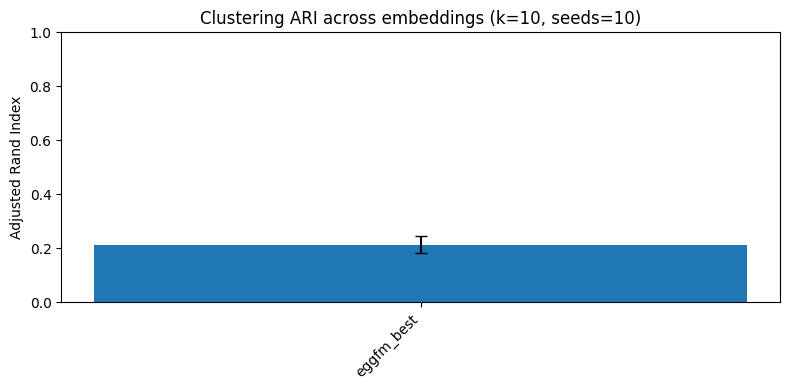

,method,mean_ari,std_ari
0,eggfm_best,0.213856,0.030524


In [12]:
# import copy

# params = {
#     "seed": 7,
#     "hvg_n_top_genes": 2000,
#     "spec": {
#         "n_pcs": 20,
#         "dcol_max_cells": 3000,
#         "ari_label_key": "Cell type annotation",  # must match adata.obs column
#         "ari_n_dims": 10,
#     },
#     "qc": {
#         "min_cells": 500,
#         "min_genes": 200,
#         "max_pct_mt": 15,
#     },
#     "eggfm_model": {
#         "hidden_dims": [512, 512, 512, 512],
#     },
#     "eggfm_train": {
#         "batch_size": 4096,
#         "num_epochs": 50,
#         "lr": 1e-4,
#         "sigma": 0.1,
#         "device": "cuda",
#     },
#     "eggfm_diffmap": {
#         "n_neighbors": 10,
#         "n_comps": 30,
#         "device": "cuda",
#         "hvp_mode": "vHv",
#         "hvp_batch_size": 4096,
#         "eps_mode": "median",
#         "eps_value": 1.0,
#         "t": 1.0,
#     },
# }


# # 1) Load data
# adata = sc.datasets.paul15()

# # 2) Preprocess in a way that mirrors your real Weinreb prep
# adata = prep_for_manifolds(
#     adata,
#     min_genes=params["qc"]["min_genes"],
#     hvg_n_top_genes=2000,
# )

# # 3) Compute manifolds + UMAPs using DCOL, Diffmap(PCA/DCOL/EGGFM), PHATE, scVI


# label_key = "paul15_clusters"
# labels = adata.obs[label_key].to_numpy()
# n_clusters = np.unique(labels).size

# # -------------------------------------------------------------------
# # Ablation grids (per-family, not all combined)
# # -------------------------------------------------------------------
# abl_n_neighbors = [10, 20, 40, 60]
# abl_t = [0.5, 1.0, 2.0, 4.0]
# abl_hvp_mode = ["Hv_norm2", "vHv"]
# abl_sigma = [0.05, 0.1, 0.2]
# abl_hidden = [
#     [256, 256, 256, 256],
#     [512, 512],
#     [512, 512, 512, 512, 512, 512],
# ]
# abl_lr = [5e-4, 1e-3, 2e-3]
# abl_batch_size = [1024, 4096]

# results = []


# # Helper to run one config and append to results
# def run_single_eggfm_ablation(
#     adata: sc.AnnData,
#     params: dict,
#     labels: np.ndarray,
#     n_clusters: int,
#     ari_k: int,
#     tag: str,
#     meta: dict,
# ):
#     # Copy AnnData so we don't accumulate neighbors/umaps/etc
#     ad = adata.copy()
#     ad, emb_dict = compute_manifolds(
#         ad,
#         params,
#         n_pcs=ari_k,
#         seed=params.get("seed", 0),
#         label_key=None,  # no plotting here
#         n_neighbors=params["eggfm_diffmap"]["n_neighbors"],
#         methods=["diffmap_eggfm"],  # only EGGFM
#     )

#     if "diffmap_eggfm" not in emb_dict:
#         print(f"[ablation] no diffmap_eggfm produced for tag={tag}, skipping")
#         return

#     emb_name = f"eggfm_{tag}"
#     df = evaluate_embeddings(
#         embeddings={emb_name: emb_dict["diffmap_eggfm"]},
#         labels=labels,
#         n_clusters=n_clusters,
#         n_seeds=10,
#         seed=0,
#         ari_k=ari_k,
#         plot=False,
#     )
#     # attach metadata columns
#     for k, v in meta.items():
#         df[k] = v
#     df["tag"] = tag
#     results.append(df)


# ari_k = params["spec"]["ari_n_dims"]

# # -------------------------------------------------------------------
# # 1) n_neighbors ablation
# # -------------------------------------------------------------------
# for nn_abln in abl_n_neighbors:
#     params = copy.deepcopy(params)
#     params["eggfm_diffmap"]["n_neighbors"] = nn_abln
#     tag = f"nnb{nn_abln}"
#     meta = {"group": "n_neighbors", "n_neighbors": nn_abln}
#     run_single_eggfm_ablation(adata, params, labels, n_clusters, ari_k, tag, meta)

# # -------------------------------------------------------------------
# # 2) diffusion time t
# # -------------------------------------------------------------------
# for t in abl_t:
#     params = copy.deepcopy(params)
#     params["eggfm_diffmap"]["t"] = t
#     tag = f"t{t}"
#     meta = {"group": "t", "t": t}
#     run_single_eggfm_ablation(adata, params, labels, n_clusters, ari_k, tag, meta)

# # -------------------------------------------------------------------
# # 3) hvp_mode: Hv_norm2 vs vHv
# # -------------------------------------------------------------------
# for mode in abl_hvp_mode:
#     params = copy.deepcopy(params)
#     params["eggfm_diffmap"]["hvp_mode"] = mode
#     tag = f"hvp_{mode}"
#     meta = {"group": "hvp_mode", "hvp_mode": mode}
#     run_single_eggfm_ablation(adata, params, labels, n_clusters, ari_k, tag, meta)

# # -------------------------------------------------------------------
# # 4) sigma in DSM
# # -------------------------------------------------------------------
# for sigma in abl_sigma:
#     params = copy.deepcopy(params)
#     params["eggfm_train"]["sigma"] = sigma
#     tag = f"sigma{sigma}"
#     meta = {"group": "sigma", "sigma": sigma}
#     run_single_eggfm_ablation(adata, params, labels, n_clusters, ari_k, tag, meta)

# # -------------------------------------------------------------------
# # 5) hidden_dims capacity
# # -------------------------------------------------------------------
# for hd in abl_hidden:
#     params = copy.deepcopy(params)
#     params["eggfm_model"]["hidden_dims"] = hd
#     tag = "hd_" + "x".join(str(h) for h in hd)
#     meta = {"group": "hidden_dims", "hidden_dims": str(hd)}
#     run_single_eggfm_ablation(adata, params, labels, n_clusters, ari_k, tag, meta)

# # -------------------------------------------------------------------
# # 6) learning rate
# # -------------------------------------------------------------------
# for lr in abl_lr:
#     params = copy.deepcopy(params)
#     params["eggfm_train"]["lr"] = lr
#     tag = f"lr{lr}"
#     meta = {"group": "lr", "lr": lr}
#     run_single_eggfm_ablation(adata, params, labels, n_clusters, ari_k, tag, meta)

# # -------------------------------------------------------------------
# # 7) batch size
# # -------------------------------------------------------------------
# for bs in abl_batch_size:
#     params = copy.deepcopy(params)
#     params["eggfm_train"]["batch_size"] = bs
#     tag = f"bs{bs}"
#     meta = {"group": "batch_size", "batch_size": bs}
#     run_single_eggfm_ablation(adata, params, labels, n_clusters, ari_k, tag, meta)

# # -------------------------------------------------------------------
# # Prettyyy
# # -------------------------------------------------------------------
# # from IPython.display import display

# if len(results) > 0:
#     all_results = pd.concat(results, ignore_index=True)
#     # display(all_results)  # show full table in the notebook
# else:
#     all_results = None
#     print("No ablation results collected.")

# all_results  # last-line expression: shows the DF or None

import copy
import numpy as np
import scanpy as sc

# ---- 0) Base params (your current dict) ----
params = {
    "seed": 7,
    "hvg_n_top_genes": 2000,
    "spec": {
        "n_pcs": 20,
        "dcol_max_cells": 3000,
        "ari_label_key": "Cell type annotation",
        "ari_n_dims": 10,
    },
    "qc": {
        "min_cells": 500,
        "min_genes": 200,
        "max_pct_mt": 15,
    },
    "eggfm_model": {
        "hidden_dims": [512, 512, 512, 512],
    },
    "eggfm_train": {
        "batch_size": 4096,
        "num_epochs": 50,
        "lr": 1e-4,
        "sigma": 0.1,
        "device": "cuda",
    },
    "eggfm_diffmap": {
        "n_neighbors": 10,
        "n_comps": 30,
        "device": "cuda",
        "hvp_mode": "vHv",
        "hvp_batch_size": 4096,
        "eps_mode": "median",
        "eps_value": 1.0,
        "t": 1.0,
    },
}

# ---- 1) Override with best-found hyperparams ----
best_params = copy.deepcopy(params)

best_params["eggfm_diffmap"]["n_neighbors"] = 40  # best from ablation
best_params["eggfm_diffmap"]["t"] = 0.5  # best t
best_params["eggfm_diffmap"]["hvp_mode"] = "Hv_norm2"  # best HVP mode

# keep hidden_dims as [512,512,512,512]
best_params["eggfm_model"]["hidden_dims"] = [512, 512, 512, 512]

# DSM hyperparams
best_params["eggfm_train"]["sigma"] = 0.1
best_params["eggfm_train"]["lr"] = 1e-3  # bump back up to 1e-3
best_params["eggfm_train"]["batch_size"] = 4096

# ---- 2) Load and preprocess paul15 ----
adata = sc.datasets.paul15()

adata = prep_for_manifolds(
    adata,
    min_genes=best_params["qc"]["min_genes"],
    hvg_n_top_genes=best_params["hvg_n_top_genes"],
)

label_key = "paul15_clusters"
labels = adata.obs[label_key].to_numpy()
n_clusters = np.unique(labels).size
ari_k = best_params["spec"]["ari_n_dims"]

# ---- 3) Run only EGGFM Diffmap with these params ----
adata_best, emb_dict = compute_manifolds(
    adata,
    best_params,
    n_pcs=ari_k,
    seed=best_params["seed"],
    label_key=None,  # set to label_key if you also want UMAP plots
    n_neighbors=best_params["eggfm_diffmap"]["n_neighbors"],
    methods=["diffmap_eggfm"],  # only EGGFM manifold
    umap_plot=False,  # or True if your version supports it
)

if "diffmap_eggfm" not in emb_dict:
    raise RuntimeError(
        "diffmap_eggfm embedding not produced; check run_eggfm_dimred wiring."
    )

# ---- 4) Evaluate ARI for this single config ----
df_best = evaluate_embeddings(
    embeddings={"eggfm_best": emb_dict["diffmap_eggfm"]},
    labels=labels,
    n_clusters=n_clusters,
    n_seeds=10,
    seed=0,
    ari_k=ari_k,
    plot=True,  # set False if you don’t want the bar plot
)

df_best

In [13]:
# adata_paul15, paul15_embeddings, paul15_df = run_paul15_manifold_panel(
#     out="out/paul15_dimred_summary.csv",
#     n_top_genes=2000,
#     n_pcs=50,
#     seed=0,
#     n_seeds=10,
# )

# Example for Paul15
# labels_cat = adata.obs["paul15_clusters"].astype("category")
# labels = labels_cat.cat.codes.to_numpy()
# n_clusters = labels_cat.cat.categories.size

# df_ari = evaluate_embeddings(
#     embeddings,
#     labels=labels,
#     n_clusters=n_clusters,
#     n_seeds=10,
#     seed=0,
#     ari_k=10,
#     plot=False,
# )
# df_ari